In [48]:
%matplotlib inline

import json
from pathlib import Path
from typing import Callable
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torchvision import transforms
from torchvision.transforms.functional import crop

mpl.rcParams['figure.dpi']= 200

In [29]:
def pil_loader(path: str) -> Image.Image:
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

class VisualGenomeDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        image_dir: str,
        metadata_dir: str,
        classes_path: str = "/private/home/rdessi/EGG/egg/zoo/referential_language/utils/classes_1600.txt",
        split: str = "train",
        transform: Callable = None,
        max_objects=20,
        image_size=64,
    ):
        super(VisualGenomeDataset, self).__init__()
        path_images = Path(image_dir)
        path_metadata = Path(metadata_dir) / f"{split}_objects.json"
        path_image_data = Path(metadata_dir) / f"{split}_image_data.json"

        with open(path_image_data) as img_in, open(path_metadata) as metadata_in:
            img_data, img_metadata = json.load(img_in), json.load(metadata_in)
        assert len(img_data) == len(img_metadata)

        get_name = lambda line: line.strip().split(",")[0]
        with open(classes_path) as fin:
            self.class2id = {get_name(line): idx for idx, line in enumerate(fin)}

        self.samples = []
        for img, objs_data in zip(img_data, img_metadata):
            assert img["image_id"] == objs_data["image_id"]
            img_path = path_images / "/".join(img["url"].split("/")[-2:])

            objs = self._filter_objs(img, objs_data["objects"])
            if len(objs) > 2:
                self.samples.append((img_path, objs))
                
            self.id2class = {v: k for k, v in self.class2id.items()}
        
        self.transform = transform
        self.max_objects = max_objects
        self.resizer = transforms.Resize(size=(image_size, image_size))

    def _filter_objs(self, img, objs):
        filtered_objs = []
        for obj in objs:
            o_name = next(filter(lambda x: x in self.class2id, obj["names"]), None)
            if o_name is None:
                continue
            obj["names"] = [o_name]

            x, y, h, w = obj["x"], obj["y"], obj["h"], obj["w"]
            img_area = img["width"] * img["height"]
            obj_area = (x + w) * (y + h)
            is_big = obj_area / img_area > 0.01 and w > 1 and h > 1
            if is_big:
                filtered_objs.append(obj)
        return filtered_objs

    def extract_object(self, image, obj_data):
        label = self.class2id[obj_data["names"][0]]
        y, x, h, w = obj_data["y"], obj_data["x"], obj_data["h"], obj_data["w"]
        # if we want to use augmentation maybe better to crop before transforming to tensor
        obj = self.resizer(crop(image, y, x, h, w))
        return obj, label

    def __getitem__(self, index):
        img_path, bboxes = self.samples[index]
        image = pil_loader(img_path)
        if self.transform:
            image = self.transform(image)

        cropped_objs, labels = [], []
        for obj in bboxes[: min(self.max_objects, len(bboxes))]:
            cropped_obj, label = self.extract_object(image, obj)
            labels.append(label)
            cropped_objs.append(cropped_obj)

        agent_input = torch.stack(cropped_objs)
        labels = torch.Tensor(labels)
        return agent_input, labels

    def __len__(self):
        return len(self.samples)


def collate(batch):
    inp, lab = [], []
    for x, l in batch:
        inp.append(x)
        lab.append(l)

    inp = torch.nn.utils.rnn.pad_sequence(inp, batch_first=True, padding_value=-1)
    lab = torch.nn.utils.rnn.pad_sequence(lab, batch_first=True, padding_value=-1)

    mask = inp[:, :, 0, 0, 0] != -1
    baseline = 1 / mask.int().sum(-1)
    bsz, max_objs = inp.shape[:2]
    game_labels = torch.arange(max_objs).repeat(bsz, 1)

    aux_input = {"mask": mask, "game_labels": game_labels, "baseline": baseline}
    return inp, lab, None, aux_input



In [53]:
def get_dataset(
    image_dir: str = "/datasets01/VisualGenome1.2/061517/",
    metadata_dir: str = "/private/home/rdessi/visual_genome/train_val_test_split_clean",
    split: str = "train",
    image_size: int = 128,
    max_objects: int = 20,
    seed: int = 111,
):
    transform = transforms.ToTensor()
    dataset = VisualGenomeDataset(
        image_dir,
        metadata_dir,
        split=split,
        transform=transform,
        max_objects=max_objects,
        image_size=image_size,
    )
    return dataset

ds = get_dataset(max_objects=8)

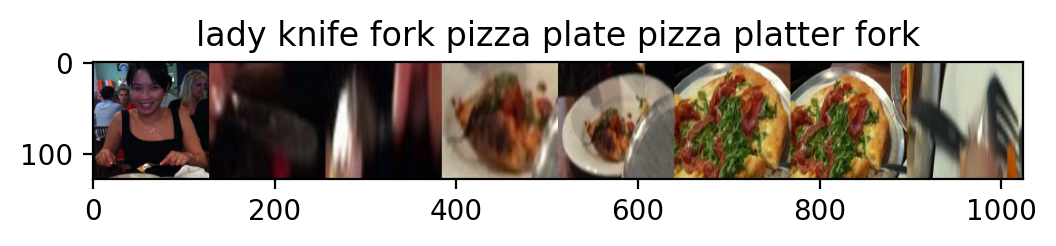

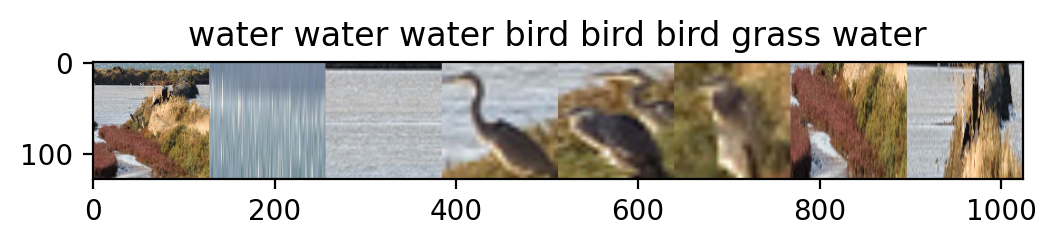

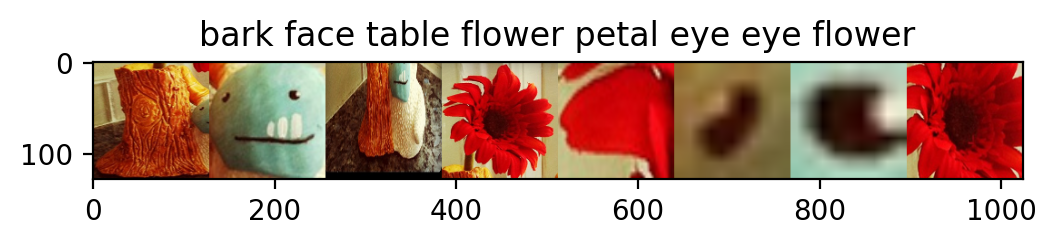

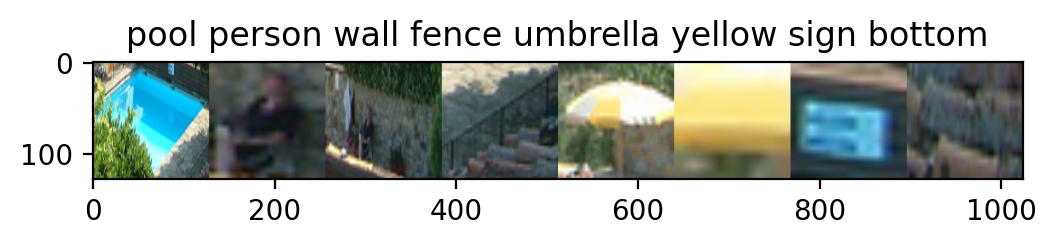

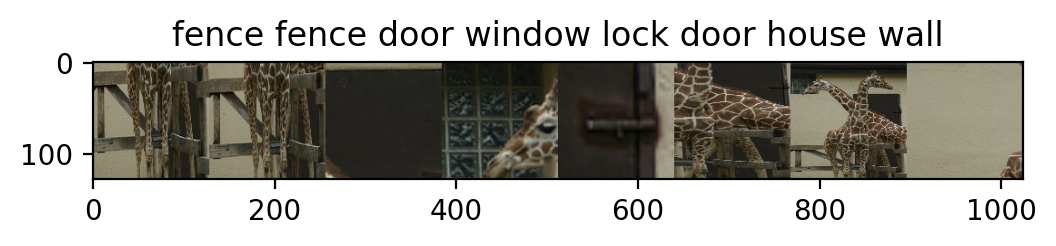

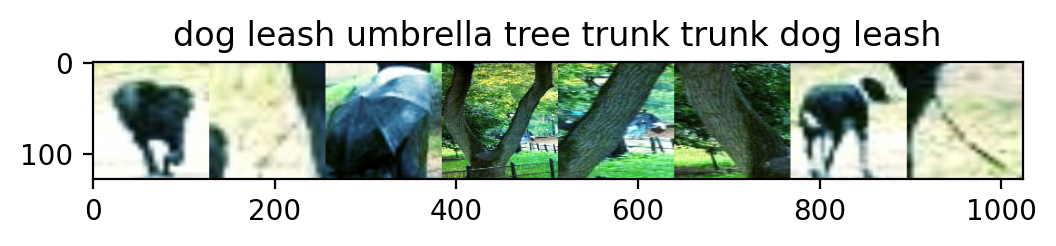

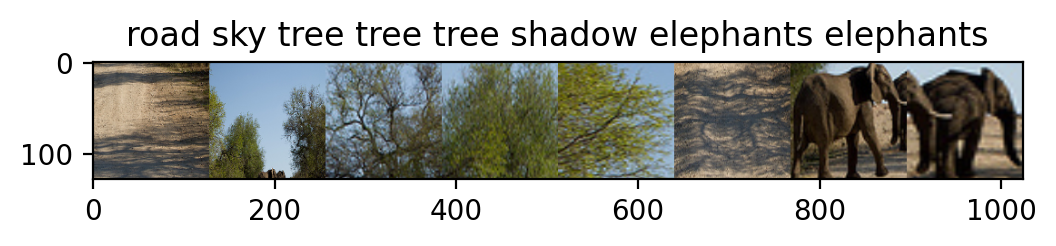

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


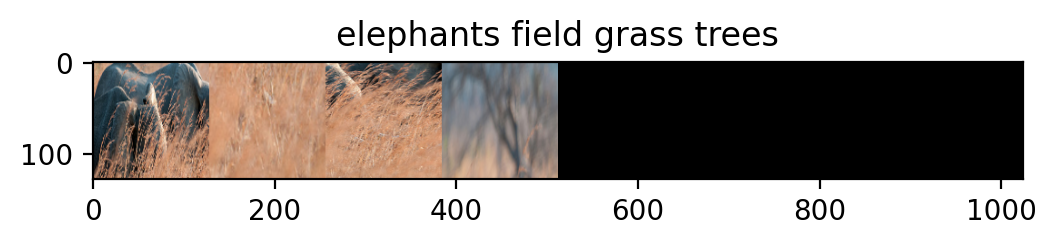

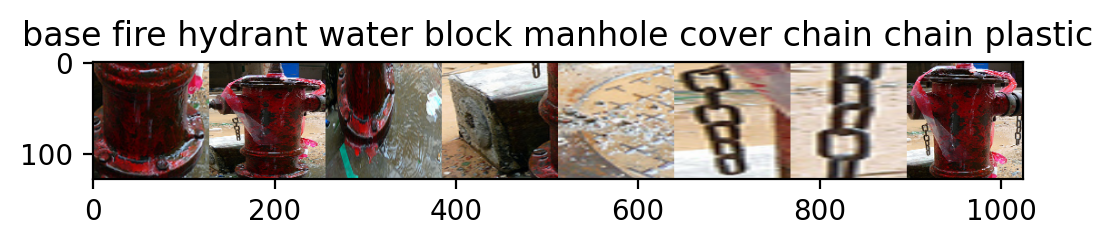

In [56]:
dl = torch.utils.data.DataLoader(
    ds,
    batch_size=4,
    num_workers=6,
    collate_fn=collate,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)

id2class = ds.id2class

idx = 0
last_obj = 8
for inp, labels, _, aux_input in dl:
    img = inp[0][0]
    all_objs = torch.cat([img.permute(1, 2, 0) for img in inp[0][:last_obj]], dim=1)

    lab = labels[0].tolist()
    title = " ".join([id2class[elem] for elem in lab[:last_obj] if elem >= 0])

    plt.title(title)
    plt.imshow(all_objs.numpy())
    plt.show()

    idx += 1
    if idx == 9:
        break
    